<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# KNN Classification and Imputation: Cell Phone Churn Data

_Authors: Kiefer Katovich (SF)_

---

In this lab, you'll practice using KNN for classification (and a little bit of regression as well).

This data set focuses on churn in cell phone plans. It has information on the usage of the phones by different account holders and whether or not they churned.

Our goal is to predict whether or not a user will churn based on the other features.

We'll also be using the KNN model to **impute** missing data. There are a couple of columns in the data set with missing values, and we can build KNN models to predict what those missing values will most likely be. This is a more advanced imputation method than just filling in the mean or median.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.neighbors import KNeighborsClassifier

### 1) Load the cell phone churn data, which contains some missing values.

In [66]:
churn = pd.read_csv('./datasets/churn_missing.csv')

### 2) Examine the data. What columns have missing values?

In [67]:
churn.isnull().sum()
#vmail_plan, vmail_message missing 400

state               0
account_length      0
area_code           0
intl_plan           0
vmail_plan        400
vmail_message     400
day_mins            0
day_calls           0
day_charge          0
eve_mins            0
eve_calls           0
eve_charge          0
night_mins          0
night_calls         0
night_charge        0
intl_mins           0
intl_calls          0
intl_charge         0
custserv_calls      0
churn               0
dtype: int64

In [68]:
churn['vmail_plan'].value_counts()

no     2130
yes     803
Name: vmail_plan, dtype: int64

In [69]:
churn['intl_plan'].value_counts()

no     3010
yes     323
Name: intl_plan, dtype: int64

### 3) Convert the `vmail_plan` and `intl_plan` columns to binary integer columns.

Make sure that if a value is missing you don't fill it in with a new value. Preserve the missing values.

In [70]:
churn['vmail_plan'] = churn['vmail_plan'].apply(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
churn['intl_plan'] = churn['intl_plan'].apply(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)

### 4) Create dummy-coded columns for the states and concatenate them to the churn data set.

> **Remember:** You'll need to leave out one of the state dummy-coded columns to serve as the "reference" column, as we'll be using these for modeling.

In [71]:
churn = pd.get_dummies(churn, columns=['state'])

### 5) Create a version of the churn data that has no missing values.

Calculate the shape.

In [72]:
churn.shape

(3333, 70)

In [76]:
churn2 = churn.dropna()
churn2.shape

(2933, 70)

### 6) Create a target vector and predictor matrix.

- The target should be the `churn` column.
- The predictor matrix should be all columns except `area_code`, `state`, and `churn`.

In [78]:
y = churn2['churn']
X = churn2.drop(['area_code','churn'], axis=1)

### 7) Calculate the baseline accuracy for `churn`.

In [98]:
1 - np.mean(y)

0.8564609614728946

In [80]:
y.value_counts()/len(y)

False    0.856461
True     0.143539
Name: churn, dtype: float64

### 8) Cross-validate a KNN model predicting `churn`. 

- The number of neighbors should be five.
- Make sure to standardize the predictor matrix.
- Set cross-validation folds to 10.

Report the mean cross-validated accuracy.

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

Xs = StandardScaler().fit_transform(X)
knn = KNeighborsClassifier(n_neighbors=5)
accs = cross_val_score(knn, Xs, y, cv=10)
print accs
print np.mean(accs)

[0.84745763 0.86054422 0.86006826 0.85665529 0.87030717 0.85665529
 0.85665529 0.85324232 0.85665529 0.85665529]
0.8574896042757937


### 9) Iterate from `k=1` to `k=49` (only odd `k`s) and cross-validate the accuracy of the model for each.

Plot the cross-validated mean accuracy for each score. What's the best accuracy?

In [90]:
max_neighbors = 49

# plot test accuracy by number of neighbors:
test_acc = []
for i in range(1, int(max_neighbors), 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc.append(np.mean(cross_val_score(knn, Xs, y, cv=10)))

In [91]:
test_acc

[0.83532037955461,
 0.8571529665837527,
 0.8574896042757937,
 0.8581698921253003,
 0.8574849765208332,
 0.856463407483662,
 0.8568035435380839,
 0.8568035435380839,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562,
 0.8564622466097562]

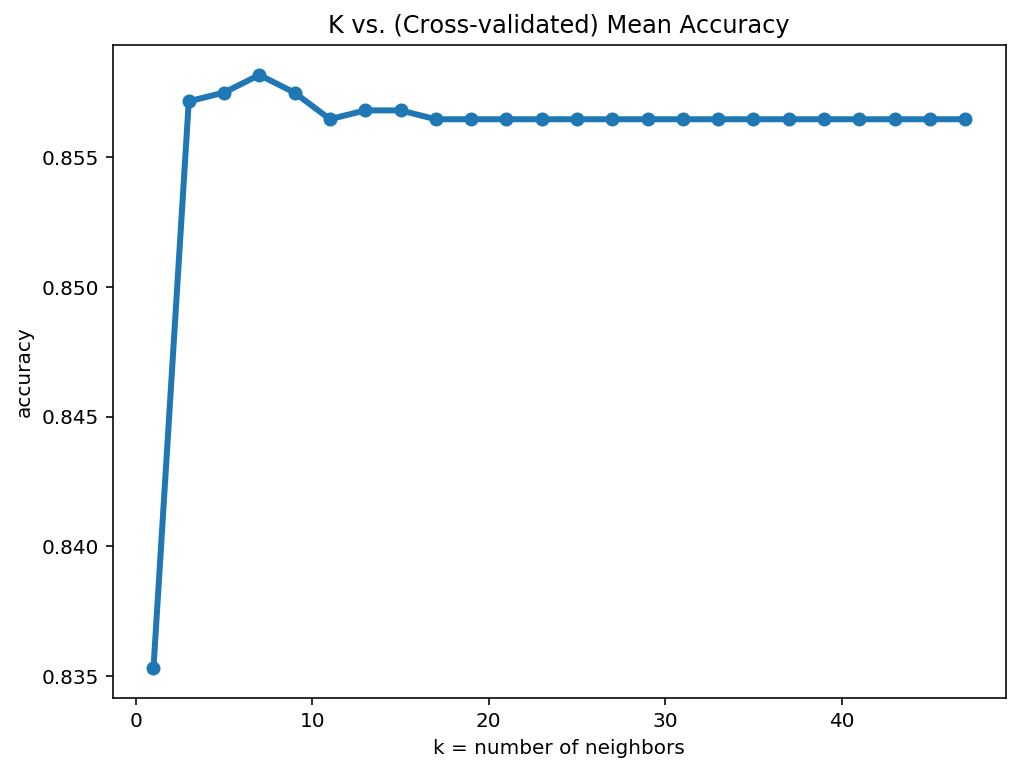

In [92]:
# plot mean acc. graph of CV
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, int(max_neighbors), 2), test_acc, lw=3., marker='o')
plt.xlabel('k = number of neighbors')
plt.ylabel('accuracy')
plt.title('K vs. (Cross-validated) Mean Accuracy')
plt.show()

### 10) Imputing with KNN.

K-nearest neighbors can be used to impute missing values in data sets. What we'll do is estimate the most likely value for the missing data based on a KNN model.

We have two columns with missing data:
- `vmail_plan`
- `vmail_message`

**10.A) Create two subsets of the churn data set: one without the missing values for `vmail_plan` and `vmail_message` and one with the missing values.**

In [113]:
df = churn.drop(['area_code','churn'], axis=1)
ms_d = df[df['vmail_plan'].isnull()]
nms_d = df.dropna()

In [114]:
print ms_d.shape
print nms_d.shape

(400, 68)
(2933, 68)


First we'll impute values for `vmail_plan`. This is a categorical column, so we'll impute using classification — predicting whether the plan is yes or no (1 vs. 0).

**10.B) Create a target for `vmail_plan` and a predictor matrix that contains all columns except `state`, `area_code`, `churn`, `vmail_plan`, and `vmail_message`.**

> **Note:** We don't include the `churn` variable in the model to impute. Why? We're imputing these missing values so that we can use the rows to predict churn with more data afterward. If we imputed with `churn` as a predictor, we'd be cheating!

In [141]:
X_vp_ms = ms_d.drop(['vmail_plan','vmail_message'], axis=1) #ms data set
X_vp_nms = nms_d.drop(['vmail_plan','vmail_message'], axis=1) #no ms data set

In [142]:
y_vp_ms = ms_d['vmail_plan']
y_vp_nms = nms_d['vmail_plan']

In [143]:
y_vm_ms = ms_d['vmail_message']
y_vm_nms = nms_d['vmail_message']

**10.C) Standardize the predictor matrix.**

In [144]:
Xs = StandardScaler().fit_transform(X_vp_nms)

**10.D) Find the best `k` for predicting `vmail_plan`.**

You may want to write a function for this. What is the accuracy for predicting `vmail_plan` at the best `k`? What is the baseline accuracy for `vmail_plan`?

In [145]:
y_vp_nms.value_counts()/len(y_vp_nms)

0.0    0.726219
1.0    0.273781
Name: vmail_plan, dtype: float64

In [146]:
max_neighbors = 49

# plot test accuracy by number of neighbors:
test_acc = []
for i in range(1, int(max_neighbors), 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc.append(np.mean(cross_val_score(knn, Xs, y_vp_nms, cv=10)))

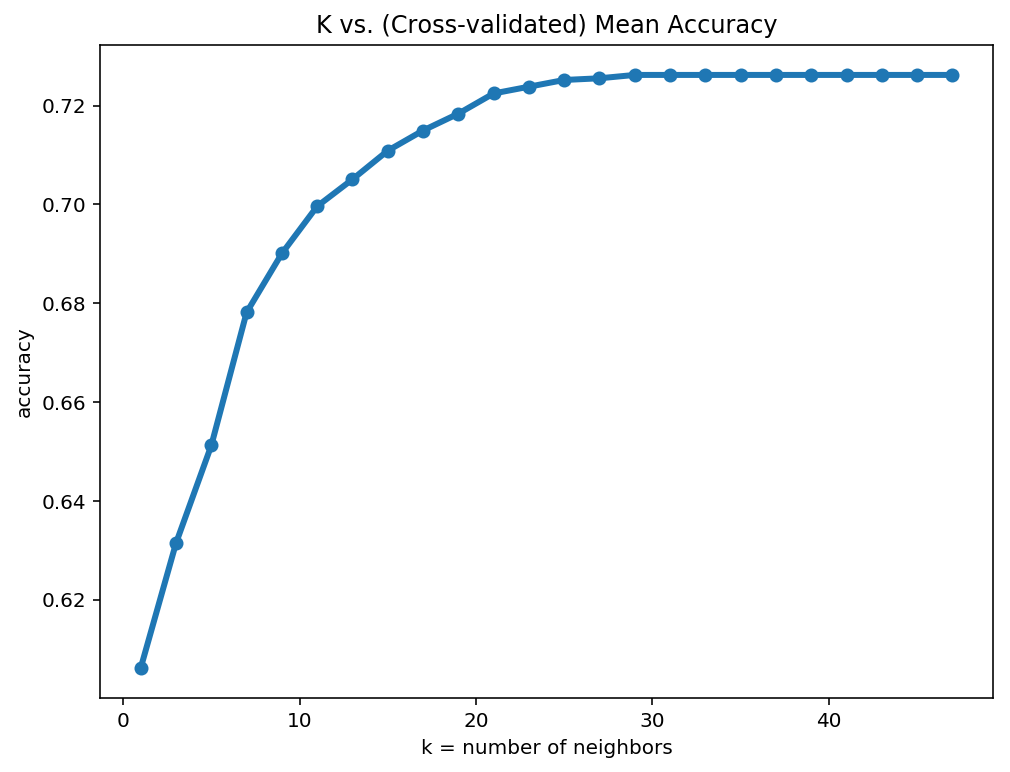

In [147]:
# plot mean acc. graph of CV
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, int(max_neighbors), 2), test_acc, lw=3., marker='o')
plt.xlabel('k = number of neighbors')
plt.ylabel('accuracy')
plt.title('K vs. (Cross-validated) Mean Accuracy')
plt.show()

**10.E) Fit a `KNeighborsClassifier` with the best number of neighbors.**

In [148]:
knn = KNeighborsClassifier(n_neighbors=49).fit(Xs, y_vp_nms)

**10.F) Predict the missing `vmail_plan` values using the subset of the data where they are missing.**

You'll need to:

    - Create a new predictor matrix using the same predictors (but from the missing subset of data).
    - Standardize this predictor matrix *using the StandardScaler object fit on the non-missing data.* This means you'll just use the `.transform()` function. It's important to standardize the new predictors the same way we standardized the original predictors if we want the predictions to make sense. Calling `.fit_transform()` will reset the standardized scale.
    - Predict what the missing `vmail_plan` values should be.
    - Replace the missing values in the original with the predicted values.

> **Note:** It may predict all 0s. This is OK. If you want to see the predicted probabilities of `vmail_plan` for each row, you can use the `.predict_proba()` function instead of `.predict()`. You can use these probabilities to manually set the criteria threshold.

In [149]:
X_pred = StandardScaler().fit_transform(X_vp_ms)

In [150]:
knn.predict_proba(X_pred)

array([[0.7755102 , 0.2244898 ],
       [0.71428571, 0.28571429],
       [0.81632653, 0.18367347],
       [0.69387755, 0.30612245],
       [0.73469388, 0.26530612],
       [0.71428571, 0.28571429],
       [0.67346939, 0.32653061],
       [0.79591837, 0.20408163],
       [0.79591837, 0.20408163],
       [0.75510204, 0.24489796],
       [0.71428571, 0.28571429],
       [0.69387755, 0.30612245],
       [0.73469388, 0.26530612],
       [0.83673469, 0.16326531],
       [0.79591837, 0.20408163],
       [0.67346939, 0.32653061],
       [0.65306122, 0.34693878],
       [0.71428571, 0.28571429],
       [0.69387755, 0.30612245],
       [0.69387755, 0.30612245],
       [0.67346939, 0.32653061],
       [0.7755102 , 0.2244898 ],
       [0.71428571, 0.28571429],
       [0.65306122, 0.34693878],
       [0.81632653, 0.18367347],
       [0.7755102 , 0.2244898 ],
       [0.71428571, 0.28571429],
       [0.67346939, 0.32653061],
       [0.81632653, 0.18367347],
       [0.79591837, 0.20408163],
       [0.

### 11) Impute the missing values for `vmail_message` using the same process.

Because `vmail_message` is essentially a continuous measure, you'll need to use `KNeighborsRegressor` instead of the `KNeighborsClassifier`.

KNN can do both regression and classification. Instead of "voting" on the class like in classifications, the neighbors will average their value for the target in regression.


In [151]:
from sklearn.neighbors import KNeighborsRegressor

In [152]:
max_neighbors = 49

# plot test accuracy by number of neighbors:
test_acc = []
for i in range(1, int(max_neighbors), 2):
    knn = KNeighborsRegressor(n_neighbors=i)
    test_acc.append(np.mean(cross_val_score(knn, Xs, y_vm_nms, cv=10)))

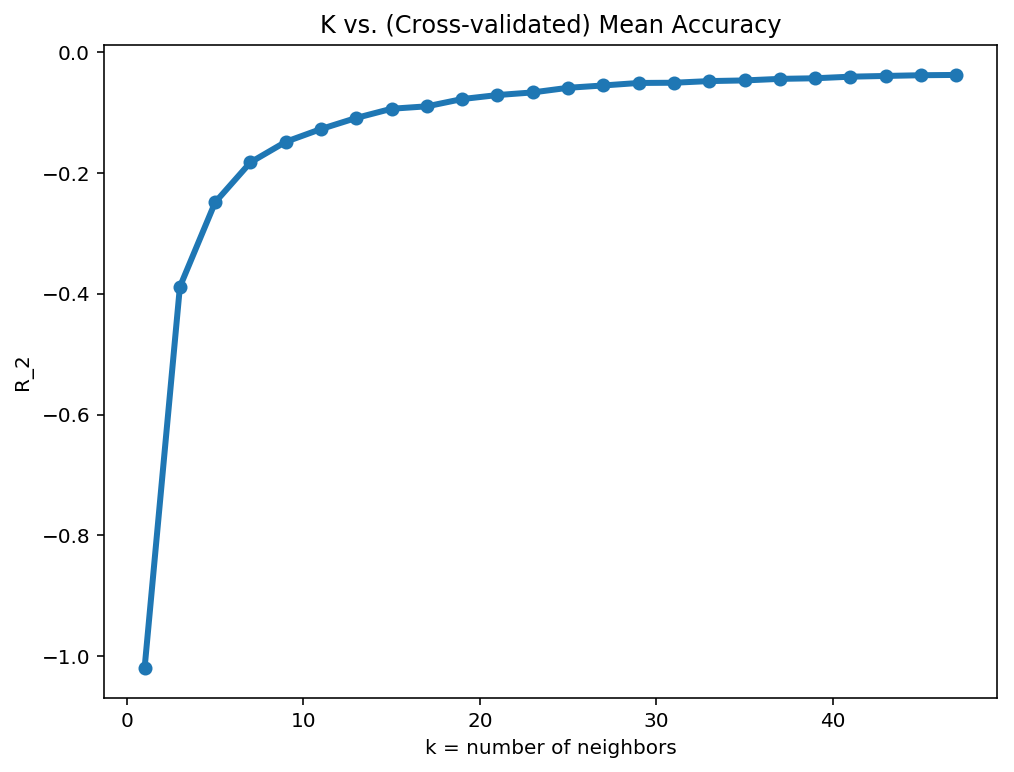

In [153]:
# plot mean acc. graph of CV
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, int(max_neighbors), 2), test_acc, lw=3., marker='o')
plt.xlabel('k = number of neighbors')
plt.ylabel('R_2')
plt.title('K vs. (Cross-validated) Mean Accuracy')
plt.show()

In [154]:
knn = KNeighborsRegressor(n_neighbors=40).fit(Xs, y_vm_nms)

(array([10., 17., 32., 38., 70., 86., 68., 49., 26.,  4.]),
 array([ 4.225,  4.99 ,  5.755,  6.52 ,  7.285,  8.05 ,  8.815,  9.58 ,
        10.345, 11.11 , 11.875]),
 <a list of 10 Patch objects>)

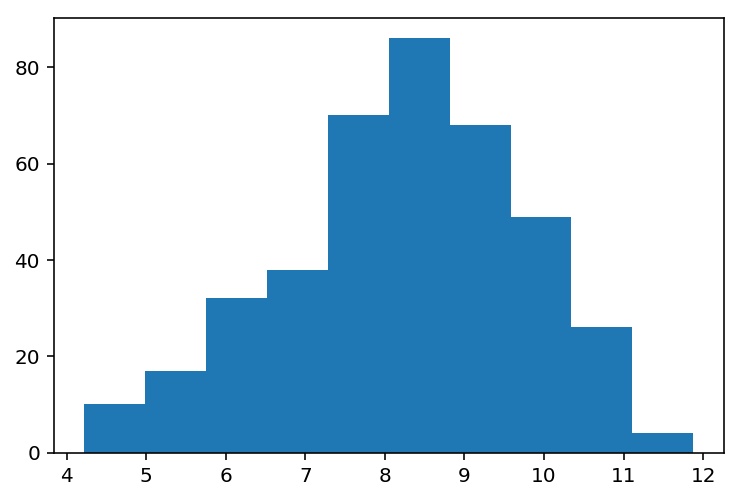

In [162]:
plt.hist(knn.predict(X_vp_ms))

### 12) Given the accuracy (and $R^2$) of your best imputation models when finding the best K neighbors, do you think imputing is a good idea?

In [164]:
# A:

### 13) With the imputed data set, cross-validate the accuracy predicting churn. Is it better? Worse? The same?

In [ ]:
# A: